# Experimenting with Ensembles
This notebook goes over a stacked ensemble model. It uses MLP, TabNet, TabPFN, and 1D CNN to predict a first layer of predictions. Then, the XGBoost model learns the difference between these model predictions and the true values. To make a final decision based on all four model predictions.

In [8]:
import torch
from torch import nn
import pytorch_lightning as pl
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, make_scorer
from scipy.stats import kendalltau
from sklearn.ensemble import RandomForestRegressor
from torch.utils.data import TensorDataset, DataLoader  # Added missing imports
from pytorch_lightning.callbacks import EarlyStopping  # Added missing import
from pytorch_tabnet.tab_model import TabNetRegressor  # Import TabNet
import seaborn as sns


## Data

In [9]:
# Loading Dataset
#data = pd.read_csv("/content/drive/MyDrive/ECE324_Project/Model/dataset.csv") # change path for your env
#data = pd.read_csv("SmartStudy\\notebooks\\database.csv") # change path for your env
data = pd.read_csv("dataset.csv") # change path for your env
data.head()

# Data Splitting & Normalization
scaler = StandardScaler()
input = data.drop(columns=['GPA'], errors='ignore')
input = scaler.fit_transform(input)
labels = data['GPA']
X_train, X_test, Y_train, Y_test = train_test_split(input, labels, test_size=0.3, random_state=42)


# Defining Individual Models

## MLP

In [10]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert X_train and Y_train to NumPy arrays if they are not already
X_np = X_train.to_numpy() if hasattr(X_train, "to_numpy") else X_train
Y_np = Y_train.to_numpy() if hasattr(Y_train, "to_numpy") else Y_train

# Define the MLP model
mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),  # Two hidden layers with 64 and 32 neurons
    activation='relu',  # Rectified Linear Unit activation function
    solver='adam',  # Adam optimizer
    max_iter=50,  # Maximum number of iterations (epochs)
    random_state=42,  # Random state for reproducibility
)

# Train the model on the full training set
mlp_model.fit(X_np, Y_np)

# Predict on the test set
mlp_pred = mlp_model.predict(X_test)

# Evaluate the model
mae_model4 = mean_absolute_error(Y_test, mlp_pred)
mse_model4 = mean_squared_error(Y_test, mlp_pred)
rmse_model4 = np.sqrt(mse_model4)
r2_model4 = r2_score(Y_test, mlp_pred)

print('Mean Absolute Error', mae_model4)
print('Mean Squared Error:', mse_model4)
print('Root Mean Squared Error:', rmse_model4)
print('R2 Score:', r2_model4)

Mean Absolute Error 0.20897831247848983
Mean Squared Error: 0.07210100939388063
Root Mean Squared Error: 0.2685163112249992
R2 Score: 0.9143727412407547


c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


## TabNet

In [11]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

X_train_xs, X_val, Y_train_xs, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

# Reshape labels for TabNet compatibility
Y_train_tabnet = Y_train_xs.values.reshape(-1, 1)  # Reshape to 2D
Y_val_tabnet = Y_val.values.reshape(-1, 1)      # Reshape to 2D

# Instantiate TabNet model
tabnet_model = TabNetRegressor()
tabnet_model.fit(
    X_train_xs, Y_train_tabnet,  # Use reshaped Y_train
    eval_set=[(X_val, Y_val_tabnet)],  # Use reshaped Y_val
    eval_metric=['mse'],
    patience=5,
    max_epochs=50
)

tabnet_pred = tabnet_model.predict(X_test)

# evaluation
mae_model5 = mean_absolute_error(Y_test, tabnet_pred)
mse_model5 = mean_squared_error(Y_test, tabnet_pred)
rmse_model5 = np.sqrt(mse_model5)
r2_model5 = r2_score(Y_test, tabnet_pred)

print('Mean Absolute Error', mae_model5)
print('Mean Squared Error:', mse_model5)
print('Root Mean Squared Error:', rmse_model5)
print('R2 Score:', r2_model5)

c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.46359 | val_0_mse: 2.38933 |  0:00:00s
epoch 1  | loss: 1.38248 | val_0_mse: 1.3858  |  0:00:00s
epoch 2  | loss: 0.95323 | val_0_mse: 1.08576 |  0:00:01s
epoch 3  | loss: 0.75773 | val_0_mse: 0.92515 |  0:00:01s
epoch 4  | loss: 0.67954 | val_0_mse: 0.76127 |  0:00:01s
epoch 5  | loss: 0.55031 | val_0_mse: 0.67934 |  0:00:02s
epoch 6  | loss: 0.43664 | val_0_mse: 0.56256 |  0:00:02s
epoch 7  | loss: 0.41001 | val_0_mse: 0.47633 |  0:00:02s
epoch 8  | loss: 0.3317  | val_0_mse: 0.42273 |  0:00:03s
epoch 9  | loss: 0.314   | val_0_mse: 0.36743 |  0:00:03s
epoch 10 | loss: 0.29514 | val_0_mse: 0.32514 |  0:00:03s
epoch 11 | loss: 0.24167 | val_0_mse: 0.31802 |  0:00:04s
epoch 12 | loss: 0.22289 | val_0_mse: 0.33679 |  0:00:04s
epoch 13 | loss: 0.20762 | val_0_mse: 0.34564 |  0:00:04s
epoch 14 | loss: 0.2164  | val_0_mse: 0.32489 |  0:00:05s
epoch 15 | loss: 0.19082 | val_0_mse: 0.3014  |  0:00:05s
epoch 16 | loss: 0.18869 | val_0_mse: 0.25728 |  0:00:05s
epoch 17 | los

c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## TabPFN

In [12]:
# imports
from tabpfn import TabPFNRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# train
reg = TabPFNRegressor(random_state=42)
reg.fit(X_train, Y_train)

# predict
tabpfn_pred = reg.predict(X_test)

# evaluation
mse_model6 = mean_squared_error(Y_test, tabpfn_pred)
mae_model6 = mean_absolute_error(Y_test, tabpfn_pred)
rmse_model6 = np.sqrt(mse_model6)
r2_model6 = reg.score(X_test, Y_test)

print('Mean Absolute Error', mae_model6)
print('Mean Squared Error:', mse_model6)
print('Root Mean Squared Error:', rmse_model6)
print('R2 Score:', r2_model6)


Mean Absolute Error 0.18530691146574615
Mean Squared Error: 0.05630139351242539
Root Mean Squared Error: 0.23727914681325327
R2 Score: 0.9331363869754131


## 1D CNN

In [13]:
class SoftOrdering1DCNN(pl.LightningModule):

    def __init__(self, input_dim, output_dim=1, sign_size=32, cha_input=16, cha_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2, learning_rate=1e-3):
        super().__init__()

        hidden_size = sign_size * cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size // 2
        output_size = (sign_size2) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output
        self.learning_rate = learning_rate

        self.batch_norm1 = nn.BatchNorm1d(input_dim)
        self.dropout1 = nn.Dropout(dropout_input)
        dense1 = nn.Linear(input_dim, hidden_size, bias=False)
        self.dense1 = nn.utils.weight_norm(dense1)

        # 1st conv layer
        self.batch_norm_c1 = nn.BatchNorm1d(cha_input)
        conv1 = nn.Conv1d(
            cha_input, 
            cha_input * K, 
            kernel_size=5, 
            stride=1, 
            padding=2,  
            groups=cha_input, 
            bias=False)
        self.conv1 = nn.utils.weight_norm(conv1, dim=None)

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size=sign_size2)

        # 2nd conv layer
        self.batch_norm_c2 = nn.BatchNorm1d(cha_input * K)
        self.dropout_c2 = nn.Dropout(dropout_hidden)
        conv2 = nn.Conv1d(
            cha_input * K, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv2 = nn.utils.weight_norm(conv2, dim=None)

        # 3rd conv layer (Output layer)
        self.batch_norm_c3 = nn.BatchNorm1d(cha_hidden)
        self.dropout_c3 = nn.Dropout(dropout_output)
        self.dense2 = nn.Linear(output_size, output_dim) 
        
        self.mse = MeanSquaredError()
        self.mae = MeanAbsoluteError()
        self.r2 = R2Score()

    def forward(self, x):
        if x.shape[1] != self.dense1.in_features:
            raise ValueError(f"Input feature size mismatch. Expected {self.dense1.in_features}, got {x.shape[1]}.")

        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = torch.relu(self.dense1(x))
        
        x = x.reshape(x.shape[0], self.cha_input, self.sign_size1) 
        
        x = self.batch_norm_c1(x)
        x = torch.relu(self.conv1(x))
        
        x = self.ave_po_c1(x)
        
        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = torch.relu(self.conv2(x))
        
        x = self.batch_norm_c3(x)
        x = self.dropout_c3(x)
        x = x.view(x.size(0), -1) 
        x = self.dense2(x)
        
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_mse', self.mse(y_hat, y))
        self.log('val_mae', self.mae(y_hat, y))
        self.log('val_r2', self.r2(y_hat, y))
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    

Y_train_numpy = Y_train_xs.to_numpy().reshape(-1, 1)
Y_val_numpy = Y_val.to_numpy().reshape(-1, 1)
Y_test_numpy = Y_test.to_numpy().reshape(-1, 1)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_xs, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_numpy, dtype=torch.float32).reshape(-1, 1) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_numpy, dtype=torch.float32).reshape(-1, 1) 
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_numpy, dtype=torch.float32).reshape(-1, 1)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=32) 
test_loader = DataLoader(test_dataset, batch_size=32)

# Instantiate the model
input_dim = X_train_tensor.shape[1]  
cnn_model = SoftOrdering1DCNN(input_dim=input_dim)

# Configure Trainer and callbacks
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)  
trainer = pl.Trainer(max_epochs=50, callbacks=[early_stopping]) 

# Train the model
trainer.fit(cnn_model, train_loader, val_loader)  # Use train and validation loaders

# Make predictions and evaluate
predictions = []
cnn_model.eval()  
with torch.no_grad():
    for x, _ in test_loader:
        predictions.append(cnn_model(x))
predictions = np.concatenate(predictions, axis=0)

# Calculate and print evaluation metrics
mse = mean_squared_error(Y_test, predictions)
mae = mean_absolute_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)
kendall_tau_corr, _ = kendalltau(Y_test, predictions)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R2 Score:', r2)

c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | batch_norm1   | BatchNorm1d       | 20     | train
1  | dropout1      | Dropout           | 0      | train
2  | dense1        | Linear            | 5.6 K  | train
3  | batch_norm_c1 | BatchNorm1d       | 32     | train
4  | conv1         | Conv1d            | 161    | train
5  | ave_po_c1     | AdaptiveAvgPool1d | 0      | train
6  | batch_norm_c2 | BatchNorm1d       | 64     

c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 14: 100%|██████████| 37/37 [00:01<00:00, 23.93it/s, v_num=7]
Mean Squared Error: 0.12849515091790872
Mean Absolute Error: 0.28855408334786736
R2 Score: 0.8473989805489484


## Correlation Heatmap
Visualizing the correlations between predictions from TabNet, 1DCNN, MLP, and TabPFN.

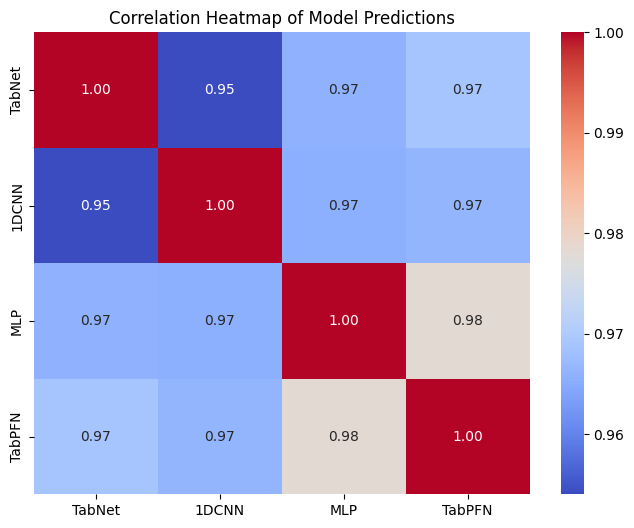

In [16]:
# Calculate correlations
correlation_matrix = ensemble_input.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Model Predictions')
plt.show()

## XGBoost Ensemble Model
This ensemble model combines predictions from TabNet, 1DCNN, MLP, and TabPFN using XGBoost to make the final prediction.

In [7]:
from xgboost import XGBRegressor
import seaborn as sns
import pandas as pd

# Generate predictions from individual models
tabnet_predictions = tabnet_model.predict(X_test)
cnn_predictions = cnn_model(torch.tensor(X_test , dtype=torch.float32))
mlp_predictions = mlp_model.predict(torch.tensor(X_test, dtype=torch.float32))
tabpfn_predictions = reg.predict(torch.tensor(X_test, dtype=torch.float32))



c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\eblac\anaconda3\envs\smartstudy_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as

In [14]:
# Flatten predictions to 1D numpy arrays
tabnet_predictions_shaped = tabnet_predictions.flatten()  # Already a numpy array
cnn_predictions_shaped = cnn_predictions.flatten().detach().numpy()  # Detach and convert to numpy
mlp_predictions_shaped = mlp_predictions.flatten()  # Detach and convert to numpy
tabpfn_predictions_shaped = tabpfn_predictions.flatten() # Detach and convert to numpy

# Combine predictions into a DataFrame
ensemble_input = pd.DataFrame({
    'TabNet': tabnet_predictions_shaped,
    '1DCNN': cnn_predictions_shaped,
    'MLP': mlp_predictions_shaped,
    'TabPFN': tabpfn_predictions_shaped
})

# Train XGBoost on the combined predictions
xgb_ensemble = XGBRegressor()
xgb_ensemble.fit(ensemble_input, Y_test)

# Make final predictions
final_predictions = xgb_ensemble.predict(ensemble_input)

# Evaluate the ensemble model
mse = mean_squared_error(Y_test, final_predictions)
mae = mean_absolute_error(Y_test, final_predictions)
r2 = r2_score(Y_test, final_predictions)

print('XGBoost Ensemble Mean Squared Error:', mse)
print('XGBoost Ensemble Mean Absolute Error:', mae)
print('XGBoost Ensemble R2 Score:', r2)

XGBoost Ensemble Mean Squared Error: 0.0008766660359070854
XGBoost Ensemble Mean Absolute Error: 0.021051334719843863
XGBoost Ensemble R2 Score: 0.9989588701998334
